In [1]:
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


class Gender_Bias():


    def __init__(self, domains):

        self.weat_file_path = "dataset/en_weat_file.txt"
        self.word_file_path = "dataset/" + str(1900) + "-vocab.pkl"
        self.embedding_file_path = "dataset/"
        self.domains = domains


    def load_embeddings(self, start, end):

        self.start = start
        self.end = end
        self.word_list = pickle.load(open(self.word_file_path, "rb"))
        self.word_dic = dict({(x, i) for (i,x) in enumerate(self.word_list)})

        self.word2vec_pkl = {}
        self.word2vec_npy = {}

        for year in range(start, end, 10):
            word_file_name = str(1800+year) + "-vocab.pkl"
            word_list = pickle.load(open(self.embedding_file_path + word_file_name, "rb"))
            word_dic = dict({(x, i) for (i,x) in enumerate(word_list)})

            vec_file_name = str(1800+year) + "-w.npy"
            word_vec = np.load(self.embedding_file_path + vec_file_name)

            self.word2vec_pkl[str(1800+year)] = word_list
            self.word2vec_npy[str(1800+year)] = word_vec


    def load_weat_words(self, female_topic="WEAT_Topic_Female", male_topic="WEAT_Topic_Male"):

        file_read = open(self.weat_file_path, "r")
        topic_dict = {}

        print("WEAT Dataset Loading")

        for line in file_read:
            data = line.strip().split(", ")
            current_topic = data[0]

            if current_topic in self.domains:
                topic_dict[current_topic] = [x.lower() for x in data[1:]]
                print(current_topic, topic_dict[current_topic])

        self.female_domain = [female_topic] + topic_dict[female_topic]
        self.male_domain = [male_topic] + topic_dict[male_topic]

        del topic_dict[female_topic]
        del topic_dict[male_topic]
        self.domain_dict = topic_dict

            
    def randomize_weat_words(self):

        for domain in self.domain_dict:
            data_list = []
            for k in range(len(self.domain_dict[domain])):
                randind = np.random.randint(0, len(self.word_list))
                data_list.append(self.word_list[randind])

            self.domain_dict[domain] = data_list


    def average_similarity_word_vs_domain(self, word_one, given_list, start, end, method="l1"):

        wordsim = []
        for year in range(start, end, 10):
            word_list = self.word2vec_pkl[str(1800+year)]
            word_dic = dict({(x, i) for (i,x) in enumerate(word_list)})

            word_vec = self.word2vec_npy[str(1800+year)]

            similarity = []
            for word_two in given_list: #["lesbian"]:
                try:
                    vec_one = np.array(word_vec[word_dic[word_one]])
                    vec_two = np.array(word_vec[word_dic[word_two]])
                except:
                    continue

                if method == "l1":
                    sim = cosine_similarity([vec_one], [vec_two])
                else:
                    sim = euclidean_distances([vec_one], [vec_two])
                similarity.append(sim[0][0])

            wordsim.append(np.average(similarity))
        
        #print("Returning Wordsim: ", len(wordsim))
        return wordsim
    
    
    def average_centroid_of_domain_vs_word(self, word_one, given_list, start, end, method="l1"):

        wordsim = []
        for year in range(start, end, 10):
            word_list = self.word2vec_pkl[str(1800+year)]
            word_dic = dict({(x, i) for (i,x) in enumerate(word_list)})

            word_vec = self.word2vec_npy[str(1800+year)]

            vectors = []
            for word_two in given_list:
                try:
                    vec_two = np.array(word_vec[word_dic[word_two]])
                    vectors.append(vec_two)
                except:
                    continue

            vec_one = np.array(word_vec[word_dic[word_one]])
            vectors = np.array(vectors)
            centroid = np.average(vectors, axis=0)
            
            if method == "l1":
                sim = cosine_similarity([vec_one], [centroid])
            else:
                sim = euclidean_distances([vec_one], [centroid])

            wordsim.append(sim[0][0])

        return wordsim


    def gender_vs_domains(self, word, group="general", method="l1"):

        domain_similarity = {}

        for domain in self.domain_dict:
            word_list = self.domain_dict[domain]
            if group == "general":
                avg_sim = self.average_similarity_word_vs_domain(word, word_list, self.start, self.end, method)
            else:
                avg_sim = self.average_centroid_of_domain_vs_word(word, word_list, self.start, self.end, method)
            
            domain_similarity[domain] = avg_sim

        return domain_similarity


    def return_gender_stats(self, gender_list, group="general", method="l1"):

        gender_association = {}

        for word in gender_list:
            domain_similarity = self.gender_vs_domains(word, group, method)
            gender_association[word] = domain_similarity
            #print("\tDomain Similarity", len(domain_similarity))
            
        return gender_association
            
    
    def create_data_store_stats(self, group="general", method="l1"): #or centroid, l2

        self.data_store = {}
        self.data_store[self.female_domain[0]] = self.return_gender_stats(self.female_domain[1:], group, method)
        self.data_store[self.male_domain[0]] = self.return_gender_stats(self.male_domain[1:], group, method)
        
    
    def dispersion_in_word_domain(self, given_list, start, end, dispersion="average", method="l2"):

        wordsim = []
        for year in range(start, end, 10):
            word_list = self.word2vec_pkl[str(1800+year)]
            word_dic = dict({(x, i) for (i,x) in enumerate(word_list)})

            word_vec = self.word2vec_npy[str(1800+year)]

            similarity = []
            vectors = []
            
            for word_two in given_list: 
                try:
                    vec = np.array(word_vec[word_dic[word_two]])
                    vectors.append(vec)
                except:
                    continue
            
            centroid = np.average(vectors, axis=0)
            
            for i in range(len(vectors)):
                if method == "l2":
                    sim = euclidean_distances([vectors[i]], [centroid])
                else:
                    sim = cosine_similarity([vectors[i]], [centroid])
                    
                similarity.append(sim[0][0])

            if dispersion == "average":
                wordsim.append(np.average(similarity))
            else:
                wordsim.append(np.var(similarity))

        return wordsim
    
    
    def compute_dispersion(self, dispersion="average", method="l2"): #Or average
        
        domain_similarity = {}
        
        for domain in self.domain_dict:
            word_list = self.domain_dict[domain]
            avg_sim = self.dispersion_in_word_domain(word_list, self.start, self.end, dispersion, method)
            
            domain_similarity[domain] = avg_sim
            
        return domain_similarity


In [2]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


color = ["red", "green", "blue", "magenta", "brown", "cyan"]
marker = ['o', 's', 'p', 'd', '>', '<']
weatset = ["Family", "Career", "Science", "Arts"] #, "Math", "Weapons"]


def compute_bias_without_plot(gender_profile_lang, dispersion, method):

    dispersion_list = []
    domain_dispersion = gender_profile_lang.compute_dispersion(dispersion=dispersion, method=method)
    #print(domain_dispersion)
    
    for subject in weatset[:]: #dataset:
        dispersion_list.append(domain_dispersion["WEAT_Topic_"+subject])
        #print(subject, domain_dispersion["WEAT_Topic_"+subject])

    return dispersion_list



# Average of Distance from Centroid within a Domain

In [3]:
#from plotting_utility import compute_bias_without_plot
import time

domains = ["WEAT_Topic_Female", "WEAT_Topic_Male", "WEAT_Topic_Family", \
                "WEAT_Topic_Career", "WEAT_Topic_Science", "WEAT_Topic_Arts"]

gender_profile_lang = Gender_Bias(domains)
gender_profile_lang.load_embeddings(start=100, end=200)

gender_profile_lang.load_weat_words()
#gender_profile_lang.create_data_store_stats()
print("Done!")

domain_dispersion_year = []
start = time.time()

for k in range(0, 1125):
    dispersion_list = compute_bias_without_plot(gender_profile_lang, "average", "l2")
    domain_dispersion_year += dispersion_list
    gender_profile_lang.randomize_weat_words()
    #print(len(domain_dispersion_year))
    #break
    
end = time.time()
#print(end-start, len(domain_dispersion_year))

WEAT Dataset Loading
WEAT_Topic_Career ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
WEAT_Topic_Family ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
WEAT_Topic_Arts ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture', 'shakespeare']
WEAT_Topic_Male ['he', 'his', 'man', 'male', 'boy', 'son', 'brother', 'father', 'uncle', 'gentleman']
WEAT_Topic_Female ['she', 'her', 'woman', 'female', 'girl', 'daughter', 'sister', 'mother', 'aunt', 'lady']
WEAT_Topic_Science ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
Done!


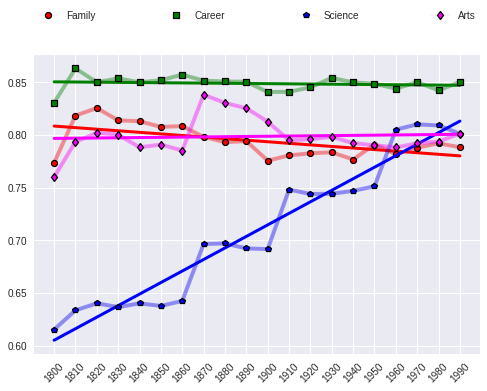

In [4]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

color = ["red", "green", "blue", "magenta", "brown", "cyan"]
marker = ['o', 's', 'p', 'd', '>', '<']
weatset = ["Family", "Career", "Science", "Arts"] #, "Math", "Weapons"]
year = [1800+x for x in range(gender_profile_lang.start, gender_profile_lang.end, 10)]

for i in range(0, 4):
    subject = weatset[i]
    slope, intercept, r_value, p_value, std_err = linregress(year, domain_dispersion_year[i])
    
    regress_assoc = slope * np.array(year) + intercept

    plt.plot(regress_assoc, linestyle='-', linewidth=3, color=color[i])

    plt.plot(domain_dispersion_year[i], color=color[i], marker=marker[i], ms=6, \
            linestyle='-', linewidth=4, alpha=0.4)
    
    plt.plot(domain_dispersion_year[i], label=subject, marker=marker[i], linewidth=0.1, \
             mfc=color[i], ms=6, mec='black', mew=1.25)
    

xaxis = [i for i in range(0, int((gender_profile_lang.end-gender_profile_lang.start)/10))]
xtick = [1800+x for x in range(gender_profile_lang.start, gender_profile_lang.end, 10)]
plt.xticks(xaxis, xtick, rotation=45)
    
plt.legend(bbox_to_anchor=(0., 1.1, 1., .102), loc=4, \
        ncol=4, mode="expand", borderaxespad=0.)

plt.show()

In [5]:
#Plotting Histogram for Significance Test

(40, 20)


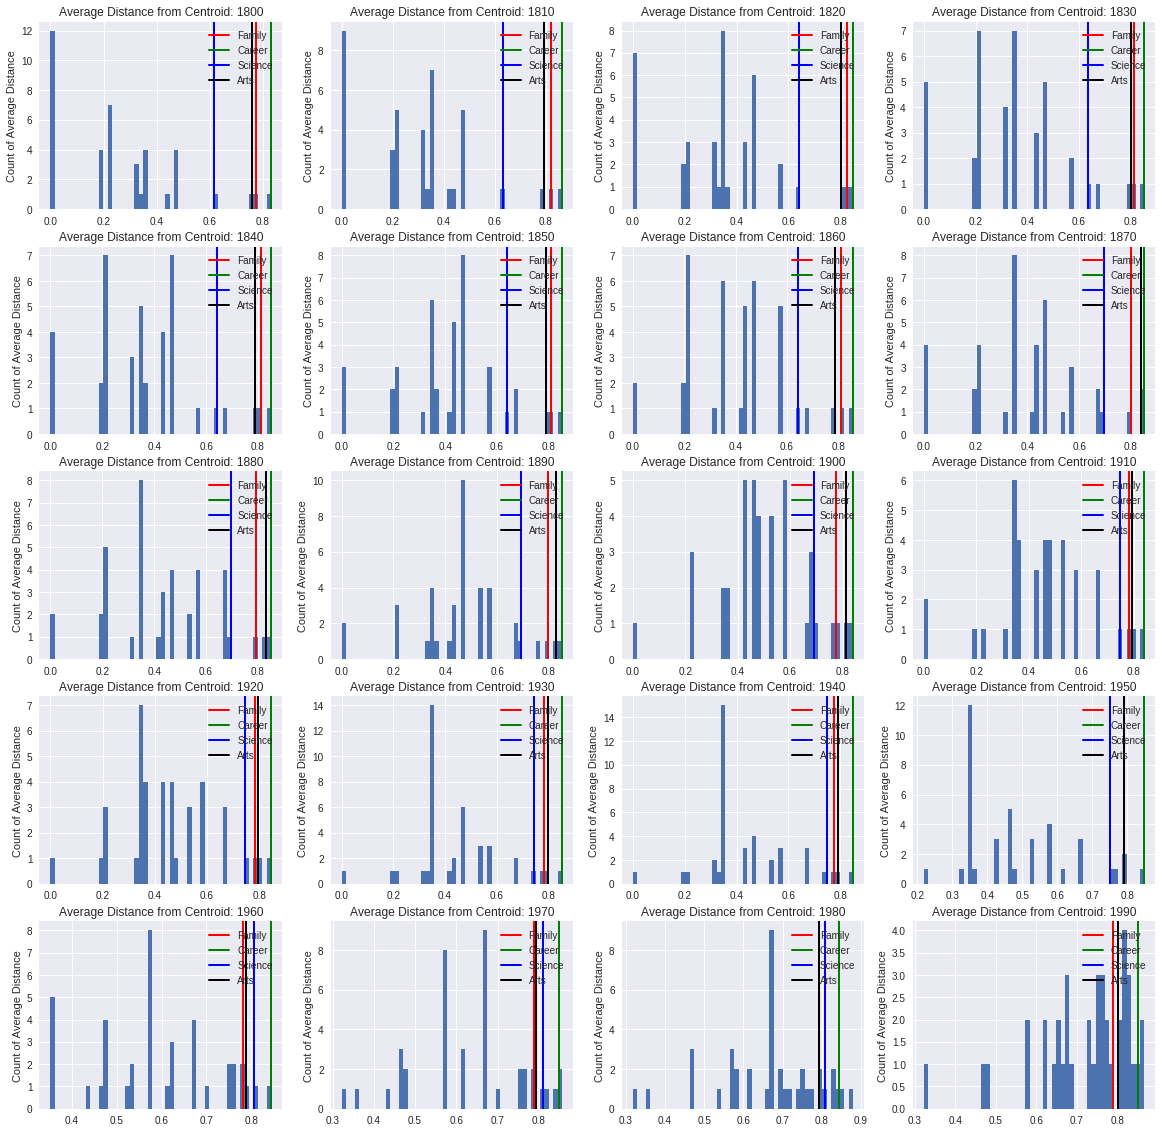

In [6]:
import matplotlib.pyplot as plt
color = ["red", "green", "blue", "black"]
domain_dispersion_year = np.array(domain_dispersion_year)
print(domain_dispersion_year.shape)

plt.figure(figsize=(20, 20))

for i in range(len(year)):
    #plt.figure(figsize=(4, 3))
    plt.subplot(5,4,i+1)
    plt.title("Average Distance from Centroid: " + str(year[i]))
    plt.ylabel("Count of Average Distance")
    
    data = domain_dispersion_year[:, i]
    plt.hist(data, bins=50)
    
    for k in range(4):
        plt.axvline(data[k], linewidth=2., \
                color=color[k], label=weatset[k])
    
    plt.legend(loc=1)
    #break
    
plt.show()
    

# Variance of Distance from Centroid within a Domain

In [3]:
#from plotting_utility import compute_bias_without_plot
import time

domains = ["WEAT_Topic_Female", "WEAT_Topic_Male", "WEAT_Topic_Family", \
                "WEAT_Topic_Career", "WEAT_Topic_Science", "WEAT_Topic_Arts"]

gender_profile_lang = Gender_Bias(domains)
gender_profile_lang.load_embeddings(start=100, end=200)

gender_profile_lang.load_weat_words()
#gender_profile_lang.create_data_store_stats()
print("Done!")

domain_dispersion_year = []
start = time.time()

for k in range(0, 1125):
    dispersion_list = compute_bias_without_plot(gender_profile_lang, "variance", "l2")
    domain_dispersion_year += dispersion_list
    gender_profile_lang.randomize_weat_words()
    #print(len(domain_dispersion_year))
    #break
    
end = time.time()
#print(end-start, len(domain_dispersion_year))

WEAT Dataset Loading
WEAT_Topic_Career ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
WEAT_Topic_Family ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
WEAT_Topic_Arts ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture', 'shakespeare']
WEAT_Topic_Male ['he', 'his', 'man', 'male', 'boy', 'son', 'brother', 'father', 'uncle', 'gentleman']
WEAT_Topic_Female ['she', 'her', 'woman', 'female', 'girl', 'daughter', 'sister', 'mother', 'aunt', 'lady']
WEAT_Topic_Science ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
Done!


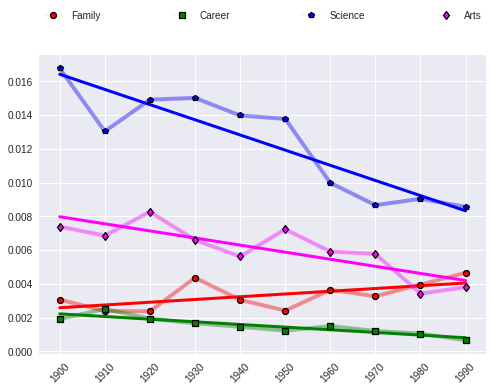

In [4]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

color = ["red", "green", "blue", "magenta", "brown", "cyan"]
marker = ['o', 's', 'p', 'd', '>', '<']
weatset = ["Family", "Career", "Science", "Arts"] #, "Math", "Weapons"]
year = [1800+x for x in range(gender_profile_lang.start, gender_profile_lang.end, 10)]

for i in range(0, 4):
    subject = weatset[i]
    slope, intercept, r_value, p_value, std_err = linregress(year, domain_dispersion_year[i])
    
    regress_assoc = slope * np.array(year) + intercept

    plt.plot(regress_assoc, linestyle='-', linewidth=3, color=color[i])

    plt.plot(domain_dispersion_year[i], color=color[i], marker=marker[i], ms=6, \
            linestyle='-', linewidth=4, alpha=0.4)
    
    plt.plot(domain_dispersion_year[i], label=subject, marker=marker[i], linewidth=0.1, \
             mfc=color[i], ms=6, mec='black', mew=1.25)
    

xaxis = [i for i in range(0, int((gender_profile_lang.end-gender_profile_lang.start)/10))]
xtick = [1800+x for x in range(gender_profile_lang.start, gender_profile_lang.end, 10)]
plt.xticks(xaxis, xtick, rotation=45)
    
plt.legend(bbox_to_anchor=(0., 1.1, 1., .102), loc=4, \
        ncol=4, mode="expand", borderaxespad=0.)

plt.show()

In [5]:
#Plotting Histogram for Significance Test

(4500, 10)


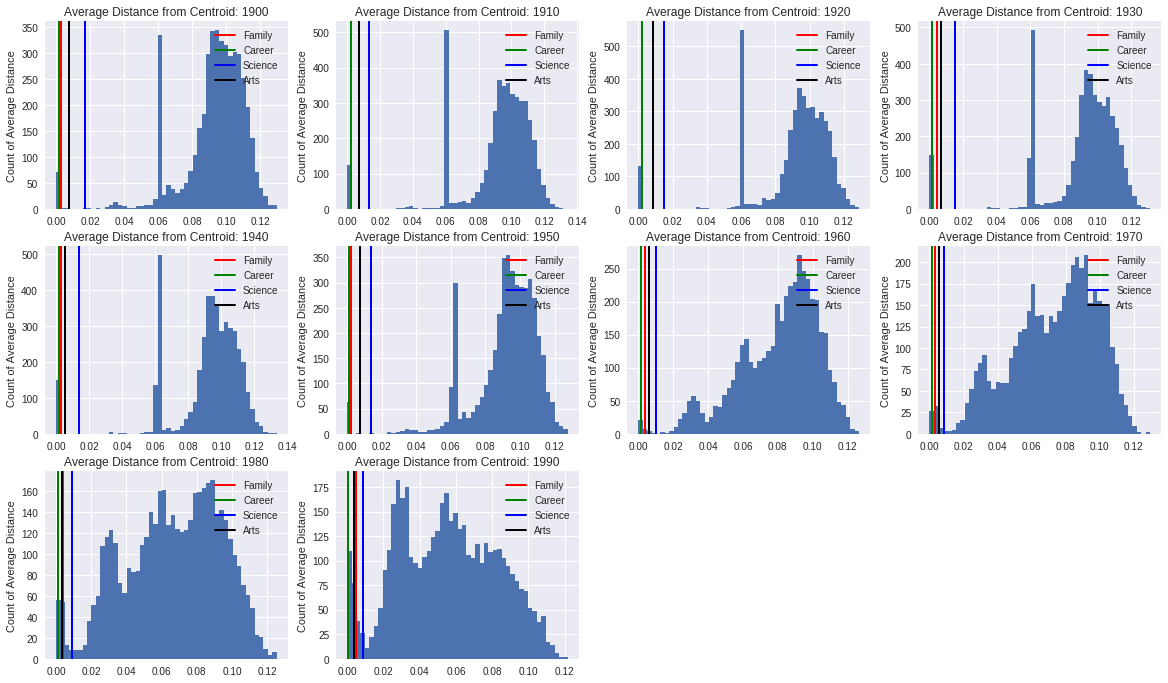

In [6]:
import matplotlib.pyplot as plt
color = ["red", "green", "blue", "black"]
domain_dispersion_year = np.array(domain_dispersion_year)
print(domain_dispersion_year.shape)

plt.figure(figsize=(20, 20))

for i in range(len(year)):
    #plt.figure(figsize=(4, 3))
    plt.subplot(5,4,i+1)
    plt.title("Average Distance from Centroid: " + str(year[i]))
    plt.ylabel("Count of Average Distance")
    
    data = domain_dispersion_year[:, i]
    plt.hist(data, bins=50)
    
    for k in range(4):
        plt.axvline(data[k], linewidth=2., \
                color=color[k], label=weatset[k])
    
    plt.legend(loc=1)
    #break
    
plt.show()
    

In [ ]:
#Test the Code Implementation